<a href="https://colab.research.google.com/github/Anpsujwal/Data-Science-Project-Series/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data exploration



In [12]:

import pandas as pd

# Load the dataset
data = pd.read_csv("/content/test.csv",encoding="latin-1")

# Display the first few rows of the dataset
print(data.head())

# Check the data types and summary statistics
print(data.info())
print(data.describe())

data.dropna(subset=['sentiment'], inplace=True)


       textID                                               text sentiment  \
0  f87dea47db  Last session of the day  http://twitpic.com/67ezh   neutral   
1  96d74cb729   Shanghai is also really exciting (precisely -...  positive   
2  eee518ae67  Recession hit Veronique Branquinho, she has to...  negative   
3  01082688c6                                        happy bday!  positive   
4  33987a8ee5             http://twitpic.com/4w75p - I like it!!  positive   

  Time of Tweet Age of User      Country  Population -2020  Land Area (Km²)  \
0       morning        0-20  Afghanistan        38928346.0         652860.0   
1          noon       21-30      Albania         2877797.0          27400.0   
2         night       31-45      Algeria        43851044.0        2381740.0   
3       morning       46-60      Andorra           77265.0            470.0   
4          noon       60-70       Angola        32866272.0        1246700.0   

   Density (P/Km²)  
0             60.0  
1            1

Data preprocessing


In [13]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split

# Download necessary NLTK packages
nltk.download('stopwords')
nltk.download('wordnet')

# Define text preprocessing functions
def preprocess_text(text):
    if not isinstance(text, str):
        return str(text)  # Convert non-string values to strings
    text = text.lower()
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words_filtered = [word for word in words if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    words_lemmatized = [lemmatizer.lemmatize(word) for word in words_filtered]
    return ' '.join(words_lemmatized)

# Load the dataset
#data = pd.read_csv("/content/test.csv",encoding="latin-1")

# Apply preprocessing to the text data
data['text'] = data['text'].apply(preprocess_text)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['sentiment'], test_size=0.2, random_state=42)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Eda


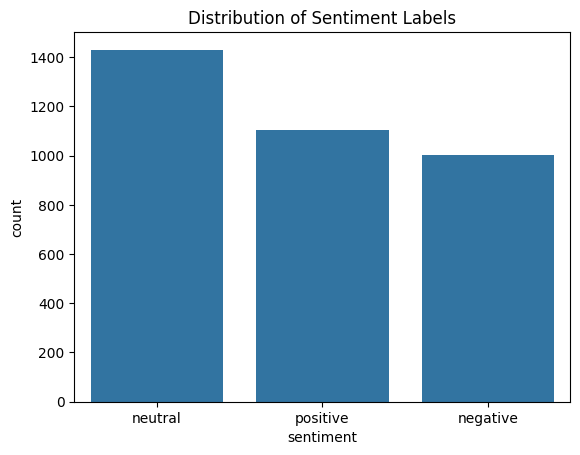

In [14]:

import seaborn as sns
import matplotlib.pyplot as plt

# Plot the distribution of sentiment labels
sns.countplot(data=data, x='sentiment')
plt.title("Distribution of Sentiment Labels")
plt.show()

Text vectorization


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data
X_test_tfidf = tfidf_vectorizer.transform(X_test)

Model selection

In [16]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Initialize the Naive Bayes classifier
model = MultinomialNB()

# Train the model
model.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred = model.predict(X_test_tfidf)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro'))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("F1 Score:", f1_score(y_test, y_pred, average='macro'))
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))

Accuracy: 0.5926449787835927
Precision: 0.6677148033126293
Recall: 0.5646817627719699
F1 Score: 0.5724874578017666
Confusion Matrix:
[[ 72 123  12]
 [ 17 234  35]
 [  3  98 113]]


Hyperparameter Tuning


In [18]:


from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to tune
param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100]
}

# Initialize GridSearchCV with the model and parameter grid
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV
grid_search.fit(X_train_tfidf, y_train)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

# Use the best model to predict
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_tfidf)

# Evaluate the best model
print("Best Model Accuracy:", accuracy_score(y_test, y_pred))
print("Best Model Precision:", precision_score(y_test, y_pred, average='macro'))
print("Best Model Recall:", recall_score(y_test, y_pred, average='macro'))
print("Best Model F1 Score:", f1_score(y_test, y_pred, average='macro'))

Best Parameters: {'alpha': 1}
Best Model Accuracy: 0.5926449787835927
Best Model Precision: 0.6677148033126293
Best Model Recall: 0.5646817627719699
Best Model F1 Score: 0.5724874578017666


Cross validation


In [19]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation on the model
scores = cross_val_score(model, X_train_tfidf, y_train, cv=5, scoring='accuracy')

# Print the mean and standard deviation of the scores
print(f"Cross-Validation Accuracy: {scores.mean():.3f} ± {scores.std():.3f}")

Cross-Validation Accuracy: 0.573 ± 0.015


Model internability


In [20]:
import numpy as np

# Get the feature names from the TF-IDF vectorizer
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())

# Get the model's feature log probabilities
feature_log_probs = model.feature_log_prob_

# Calculate the top positive and negative features
top_positive_features = feature_names[np.argsort(feature_log_probs[1])[::-1][:10]]
top_negative_features = feature_names[np.argsort(feature_log_probs[0])[::-1][:10]]

print("Top 10 Positive Features:", top_positive_features)
print("Top 10 Negative Features:", top_negative_features)

Top 10 Positive Features: ['it' 'work' 'go' 'know' 'get' 'got' 'http' 'back' 'lol' 'day']
Top 10 Negative Features: ['miss' 'sad' 'it' 'sorry' 'im' 'feel' 'like' 'work' 'bad' 'hate']


Evaluation metrics


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


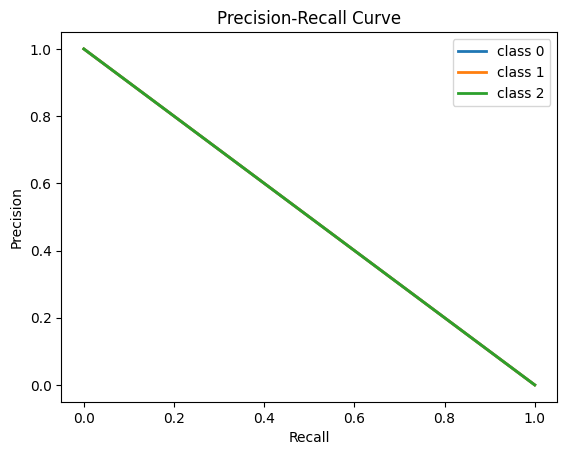

In [37]:
from sklearn.preprocessing import label_binarize

# Binarize the labels
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])  # Assuming you have 3 classes (0, 1, 2)

# Calculate the precision-recall curve
precision = dict()
recall = dict()
for i in range(y_test_binarized.shape[1]):  # Use shape[1] to get the number of classes
    precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i], model.predict_proba(X_test_tfidf)[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="best")
plt.title("Precision-Recall Curve")
plt.show()


